# Multi-class Classification and Neural Networks

In [43]:
%matplotlib inline
# To get nice quality plots
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as sop
from scipy.io import loadmat

## Multi-class classification

### Read Data

In [44]:
data = loadmat('data/ex3data1.mat')
X = data['X']
y = data['y']
print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (5000, 400), y shape: (5000, 1)


### Visualize Data

In [45]:
# Function to show some random immages of handwritten numbers
def display_data(X, nr_examples):
    m, n = X.shape
    example_width = int(np.round(np.sqrt(n)))
    example_height = n // example_width
    
    display_rows = int(np.floor(np.sqrt(nr_examples)))
    display_cols = int(np.ceil(nr_examples / display_rows))
    
    _, axarr = plt.subplots(display_rows, display_cols, figsize=(display_rows, display_cols))
    
    for i in range(display_rows):
        for j in range(display_cols):
            axarr[i,j].imshow(X[np.random.randint(m)].reshape(example_width, example_height, order = 'F'), 
                              cmap='gray')
            axarr[i,j].axis('off')

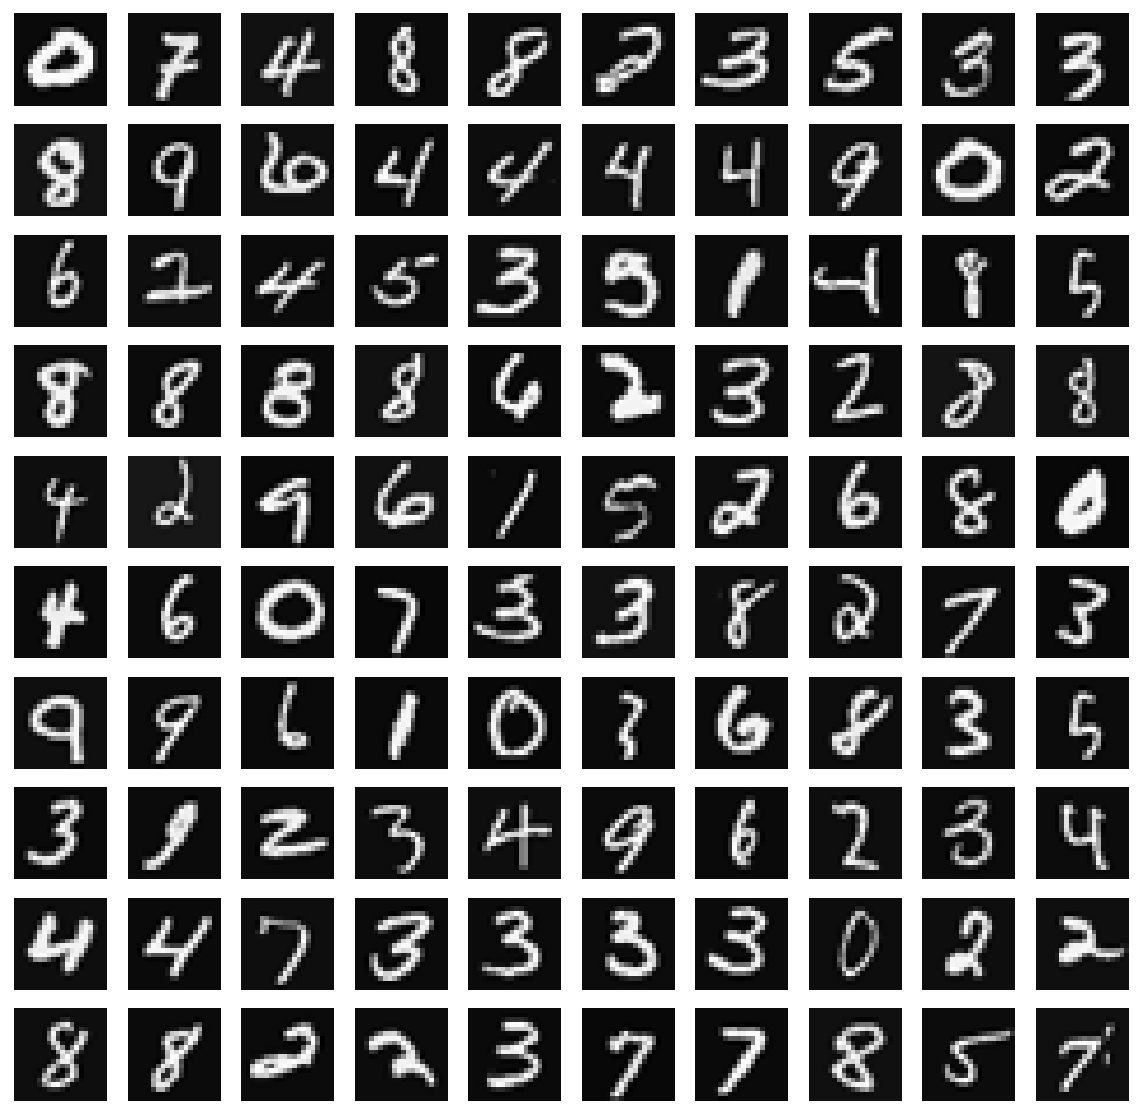

In [46]:
# Show some images in the dataset
display_data(X, 100)

### Model

In [47]:
# Sigmoid function
def sigmoid(z):
    return 1/(1 + np.exp(-z))

In [48]:
# Unregularized cost function and gradient
def costFunction(theta, X, y):
    m = len(y)
    h = sigmoid(X @ theta)
    return (-(1/m) * (y.T @ np.log(h) + ((1 - y).T) @ np.log(1 - h))).item()

def costGradient(theta, X, y):
    m = len(y)
    h = sigmoid(X @ theta)
    return (1/m) * X.T @ (h - y)

# Regularized cost function and gradien
def costFunctionReg(theta, X, y, lam):
    return costFunction(theta, X, y) + lam/(2 * len(y)) * np.sum(theta[1:] ** 2)

def costGradientReg(theta, X, y, lam):
    grad = costGradient(theta, X, y)
    grad[1:] = grad[1:] + lam/len(y) * theta[1:]
    return grad

In [49]:
# One vs all logistic regressioN:
def oneVsAll(X, y, num_labels, l, max_iter):
    (m, n) = X.shape
    all_theta = np.zeros((num_labels, n + 1))
    # Add bias term
    Xb = np.c_[np.ones((m, 1)), X]
    # Initial theta
    init_theta = np.zeros((n + 1, 1))
    
    for k in range(num_labels):
        # Notice we have to write y.ravel() == k + 1 because in the label data 0 is represented as 10
        all_theta[k] = sop.minimize(costFunctionReg, x0 = init_theta.ravel(), jac=costGradientReg, \
                                    args = (Xb, y.ravel() == k + 1, l), method='CG', options = {'maxiter': max_iter}).x
    return all_theta

In [50]:
# Define parameters
lam = 0.1
num_labels = 10
max_iter = 50

# Train the model
theta_opt = oneVsAll(X, y, 10, lam, max_iter)

### Results

In [51]:
theta_opt.shape

(10, 401)

In [52]:
def predictOneVsAll(all_theta, X):
    (m, n) = X.shape
    num_labels = all_theta.shape[0]
    Xb = np.c_[np.ones((m, 1)), X]
    return (np.argmax(sigmoid(Xb @ all_theta.T), axis = 1) + 1)

In [53]:
# Make prediction based on learned parameters
pred = predictOneVsAll(theta_opt, X)

# Calculate percentage of correct classifications on training set
np.mean(pred == y.flatten())

0.9514

## Neural Networks

### Load pre-learned Weights

In [54]:
data = loadmat('data/ex3weights.mat')
Theta1 = data['Theta1']
Theta2 = data['Theta2']
print("Shape of Theta1: ", Theta1.shape, "\nShape of Theta2: ", Theta2.shape)

Shape of Theta1:  (25, 401) 
Shape of Theta2:  (10, 26)


### Predictions

In [55]:
# Feedforward propagation and prediction
def predict(Theta1, Theta2, X):
    # m1 is the input layer size
    m1 = X.shape[0]
    # Input Layer: add bias column to X
    a1 = np.c_[np.ones((m1, 1)), X]
    # Hidden Layer: calculate activation
    z2 = a1 @ Theta1.T
    a2 = np.c_[np.ones((m1, 1)), sigmoid(z2)]
    # Output Layer: calculate activation
    z3 =  a2 @ Theta2.T
    # no need to add bias unit!
    a3 = sigmoid(z3)
    # calculate actual predictions
    return {"predictions": np.argmax(a3, axis=1) + 1, "scores": np.max(a3, axis=1)}

In [56]:
pred = predict(Theta1, Theta2, X)

# Calculate ratio of correct classifications on training set
np.mean(pred["predictions"] == y.flatten())

0.9752

In [57]:
def show_ground_truth_and_prediction(index, X, y, pred):
    X_sample = X[index]
    y_val = y[index][0]
    pred_val = pred["predictions"][index]
    pred_score = pred["scores"][index]

    _, ax = plt.subplots()
    ax.imshow(X_sample.reshape(20, 20, order = 'F'), cmap='gray')
    ax.axis('off')
    print(f"Ground truth label: {y_val if y_val < 10 else 0}")
    print(f"Prediction:         {pred_val if pred_val < 10 else 0} (score: {pred_score:.4})")
    plt.show()

Ground truth label: 8
Prediction:         8 (score: 0.7125)


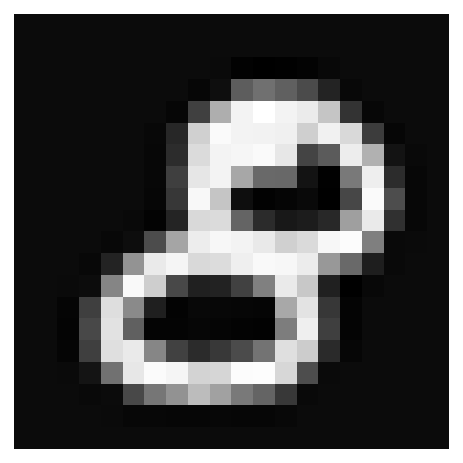

Ground truth label: 0
Prediction:         0 (score: 0.5995)


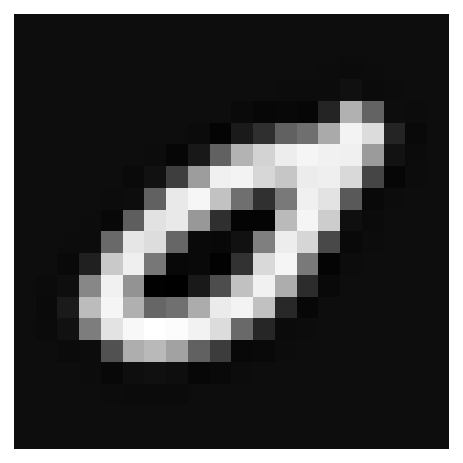

Ground truth label: 1
Prediction:         1 (score: 0.9773)


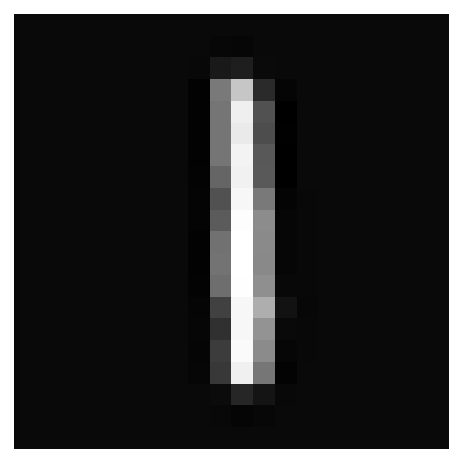

In [58]:
# Test it on an example image of training data
for index in [4242, 133, 798]:
    show_ground_truth_and_prediction(index, X, y, pred)

In [59]:
# Check wrong predictions:
(wrong_prediction_indices,) = np.where(pred["predictions"] != y.flatten())
len(wrong_prediction_indices)

124

In [69]:
def create_confusion_matrix(y_true, y_pred):
    num_classes = len(np.unique(y_true))
    num_samples = len(y_true)
    confusion_matrix = np.zeros((num_classes, num_classes), dtype=int)
    for i in range(num_samples):
        confusion_matrix[y_true[i] - 1][y_pred[i] - 1] += 1
    return confusion_matrix

In [71]:
# Confusion matrix
confusion_matrix_df = pd.DataFrame(create_confusion_matrix(y.ravel(), pred["predictions"]), range(1, 11), range(1, 11))
confusion_matrix_df

,1,2,3,4,5,6,7,8,9,10
1,491,1,1,2,0,0,1,3,1,0
2,1,485,0,3,1,3,1,2,1,3
3,2,2,480,0,8,1,4,1,2,0
4,2,2,0,484,0,3,0,1,8,0
5,0,1,4,1,492,2,0,0,0,0
6,2,0,0,0,3,493,0,0,0,2
7,3,2,1,4,0,0,485,0,4,1
8,4,1,1,2,1,0,0,491,0,0
9,2,0,4,2,1,1,5,3,479,3
10,0,0,0,1,0,1,0,1,1,496


Ground truth label: 7
Prediction:         4 (score: 0.4587)


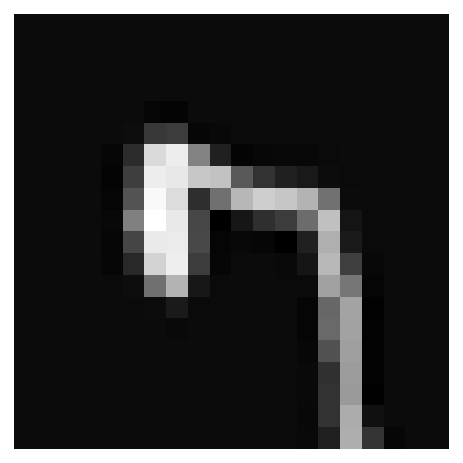

Ground truth label: 2
Prediction:         8 (score: 0.7189)


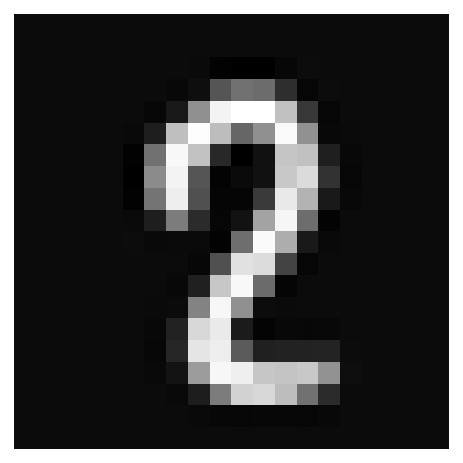

Ground truth label: 4
Prediction:         6 (score: 0.1284)


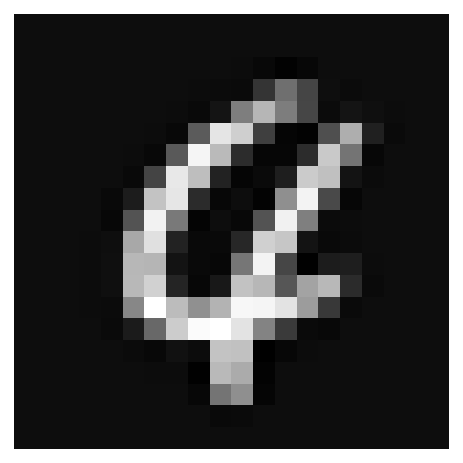

In [18]:
# Look at some wrong predictions
for index in np.random.choice(wrong_prediction_indices, size=3):
    show_ground_truth_and_prediction(index, X, y, pred)